# Project: Stock Prices Prediction

## Langtian Bian

### Introduction

Stock exchange trading has long fascinated people around the world. Trying to predict the
stock market is an exciting prospect to every one of us.
At the same time, machine learning is a good tool for us to process and predict the data.
There are many techniques that we can use for predicting stock prices like linear regression
and long short-term memory and so on. So, I want to use the tools studied in this class to try
to predict the stock price and employ the data to testify my model to see if the model is
accurate enough and whether people can truly predict the stock.

First it’s important to establish what we’re aiming to solve. Broadly, stock market analysis is divided into two parts – Fundamental Analysis and Technical Analysis.

As you might have guessed, our focus will be on the technical analysis part. I used the data ‘Tata Global Beverages’ which is attached in the file.

We will first load the dataset and define the target variable for the problem:

In [1]:
import pandas as pd
import numpy as np
import fastai
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.linear_model import LinearRegression
from fastai.tabular import add_datepart
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.read_csv('NSE-TATAGLOBAL.csv')
df.head()

Using TensorFlow backend.
C:\Users\billbian\.conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\billbian\.conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\billbian\.conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\billbian\.conda\envs\py36\lib\site-packag

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


There are multiple variables in the dataset – date, open, high, low, last, close, total_trade_quantity, and turnover.

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
High, Low and Last represent the maximum, minimum, and last price of the share for the day.
Total Trade Quantity is the number of shares bought or sold in the day and Turnover (Lacs) is the turnover of the particular company on a given date.
Another important thing to note is that the market is closed on weekends and public holidays. Notice the above table again, some date values are missing.

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

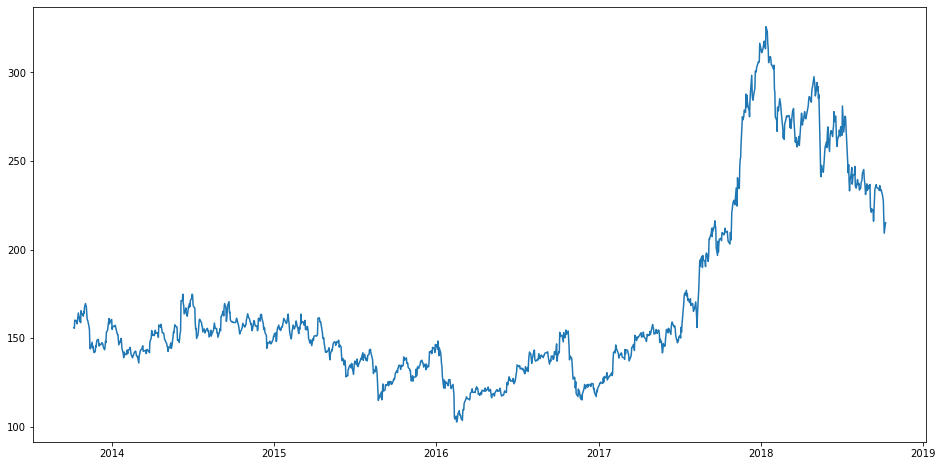

In [2]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In the upcoming sections, we will explore these variables and use different techniques to predict the daily closing price of the stock.

#### Moving Average

The predicted closing price for each day will be the average of a set of previously observed values. Instead of using the simple average, we will be using the moving average technique which uses the latest set of values for each prediction. In other words, for each subsequent step, the predicted values are taken into consideration while removing the oldest observed value from the set.


We will implement this technique on our dataset. The first step is to create a dataframe that contains only the Date and Close price columns, then split it into train and validation sets to verify our predictions.

In [6]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

train = new_data[:999]
valid = new_data[999:]
preds = []
for i in range(0,valid.shape[0]):
    a = train['Close'][len(train)-248+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('RMSE value on validation set:')
print(rms)

RMSE value on validation set:
9.808838894303465


Just checking the RMSE does not help us in understanding how the model performed. Let’s visualize this to get a more intuitive understanding. So here is a plot of the predicted values along with the actual values.

C:\Users\billbian\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\billbian\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


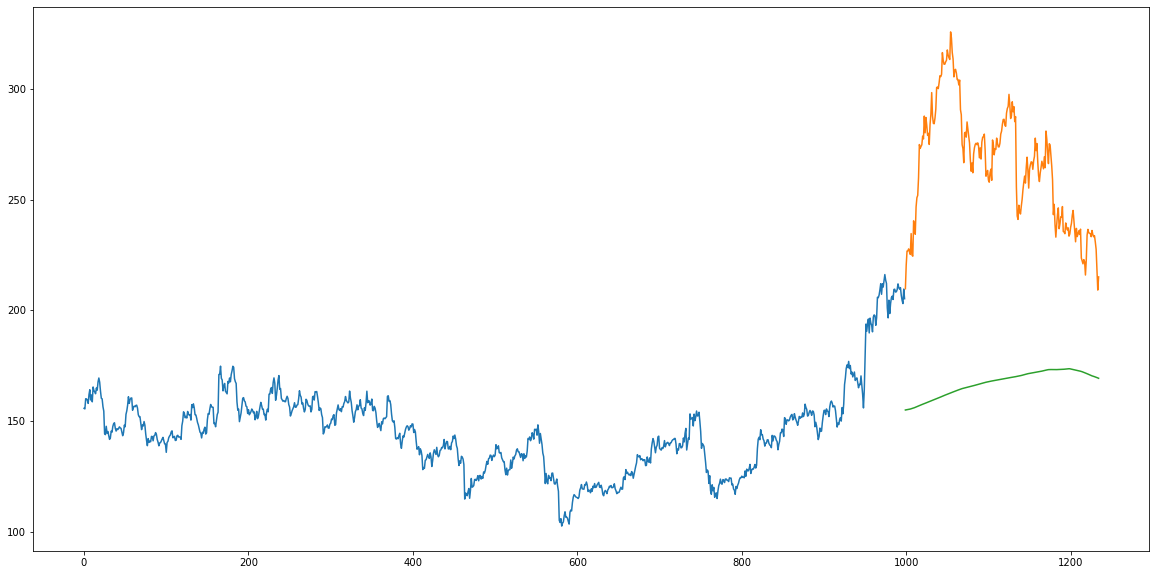

In [4]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

The RMSE value is close to 105 but the results are not very promising (as you can gather from the plot). After all, it's a very rough model and the stock markets are way more complex and difficult. So let's continue to use some complicated models to predict.

#### Linear Regression

We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [8]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [7]:
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)

This creates features such as:

‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’.

Apart from this, we can add our own set of features that we believe would be relevant for the predictions. For instance, my hypothesis is that the first and last days of the week could potentially affect the closing price of the stock far more than the other days. So I have created a feature that identifies whether a given day is Monday/Friday . This can be done using the following lines of code:

In [6]:
pd.options.mode.chained_assignment = None
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

If the day of week is equal to 0 or 4, the column value will be 1, otherwise 0. Similarly, you can create multiple features.

We will now split the data into train and validation sets to check the performance of the model.

In [7]:
train = new_data[:987]
valid = new_data[987:]
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [8]:
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

121.16291596523709

The RMSE value is 121, which clearly shows that linear regression has performed poorly. Let’s look at the plot and understand why linear regression has not done well:

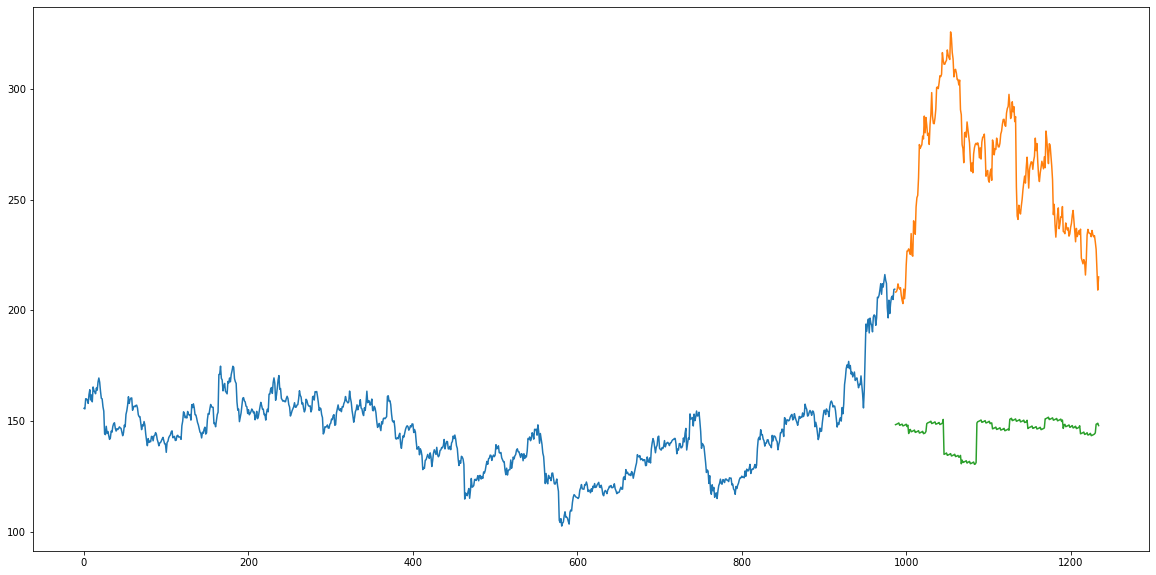

In [9]:
valid['Predictions'] = 0
valid['Predictions'] = preds
valid.index = new_data[987:].index
train.index = new_data[:987].index
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

Linear regression is a simple technique and quite easy to interpret, but there are a few obvious disadvantages. One problem in using regression algorithms is that the model overfits to the date and month column. Instead of taking into account the previous values from the point of prediction, the model will consider the value from the same date a month ago.

As seen from the plot above, for January 2016 and January 2017, there was a drop in the stock price. The model has predicted the same for January 2018. A linear regression technique can perform well for problems where the independent features are useful for determining the target value.

#### k-Nearest Neighbours

Using the same train and validation set from the last section:

In [10]:
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [11]:
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

115.17086550026721

There is not a huge difference in the RMSE value, but a plot for the predicted and actual values should provide a more clear understanding.

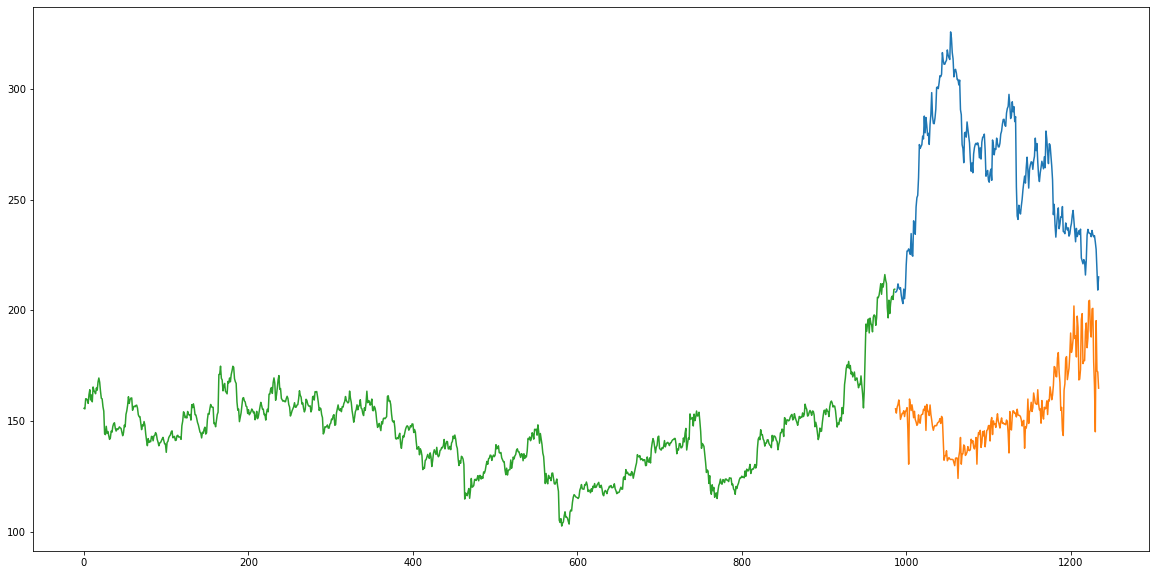

In [12]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

The RMSE value is almost similar to the linear regression model and the plot shows the same pattern. Like linear regression, kNN also identified a drop in January 2018 since that has been the pattern for the past years. We can safely say that regression algorithms have not performed well on this dataset.

#### Long Short Term Memory (LSTM)

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

The input gate: The input gate adds information to the cell state

The forget gate: It removes the information that is no longer required by the model

The output gate: Output Gate at LSTM selects the information to be shown as output

For now, let us implement LSTM as a black box and check it’s performance on our particular data.

In [4]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
dataset = new_data.values
train = dataset[0:987,:]
valid = dataset[987:,:]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


Epoch 1/10
 - 27s - loss: 0.0030
Epoch 2/10
 - 26s - loss: 0.0012
Epoch 3/10
 - 26s - loss: 0.0010
Epoch 4/10
 - 26s - loss: 8.7273e-04
Epoch 5/10
 - 27s - loss: 6.5790e-04
Epoch 6/10
 - 27s - loss: 5.3089e-04
Epoch 7/10
 - 26s - loss: 6.6452e-04
Epoch 8/10
 - 26s - loss: 6.4601e-04
Epoch 9/10
 - 26s - loss: 5.6470e-04
Epoch 10/10
 - 26s - loss: 5.2084e-04


In [9]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

Close          3.440667
Predictions    0.000000
dtype: float64

C:\Users\billbian\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


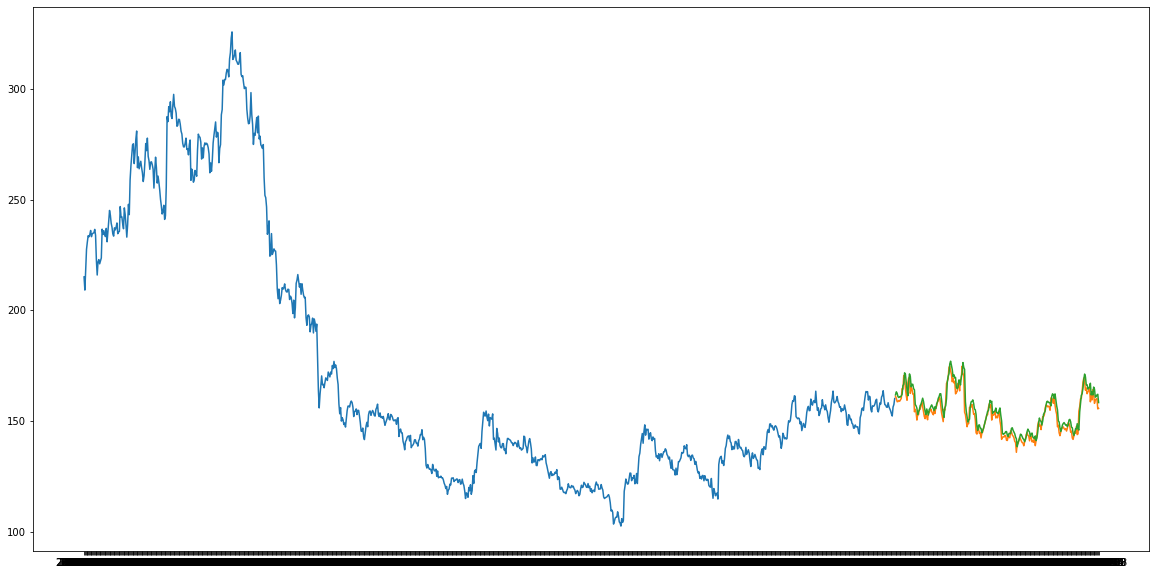

In [10]:
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

As you can see from the RMSE and the plot, the LSTM model is the best model that can make relatively accurate predictions, the predicted value is almost the same as the actual value. Since the LSTM model can be tuned for various parameters such as changing the number of LSTM layers, adding dropout value or increasing the number of epochs. But does this mean that we can use this model to predict the future stock prices? Are the predictions from LSTM enough to identify whether the stock price will increase or decrease? Certainly not!

As I mentioned at the start, stock price is affected by many factors like merger/demerger of the companies. There are certain intangible factors as well which can often be impossible to predict beforehand.

YouTube link：https://www.youtube.com/watch?v=XbJzi-qa1xM